## Mean-Variance Optimization

In [1]:
from _config import *
from scipy.optimize import minimize 

In [2]:
stocks = pd.read_csv('data/ff100port.csv').assign(date = lambda x: pd.to_datetime(x['yyyymm'], format = r'%Y%m') + MonthEnd(0)).drop(columns = 'yyyymm')

stocks = stocks[stocks['date'] >= '1970-01-01'].set_index('date')
stocks /= 100

In [3]:
def minimize_var(eret, cov, target, wt_bounds):
    
    n = len(eret)
    
    def obj_fcn(w: np.array):
        return w.T @ cov @ w
    
    def constr_wts(w: np.array):
        return np.sum(w) - 1

    def constr_pret(w: np.array):
        return w.T @ eret - target
    
    wts ={'type': 'eq', 'fun': constr_wts}
    pret = {'type': 'eq', 'fun': constr_pret}
    
    bounds = [wt_bounds for _ in range(n)]
    
    x0 = np.ones(n) / n
    
    res = minimize(
        obj_fcn, 
        x0, 
        method = 'SLSQP',
        constraints = [wts, pret], 
        bounds = bounds
    )
    
    return res

In [4]:
eret = stocks.mean()
cov = stocks.cov()

targets = np.linspace(0.013, 0.04, num = 100, endpoint = True)
std = []
for target in targets:
    res = minimize_var(eret, cov, target, (-1, 1))
    std.append(np.sqrt(res.fun))
    
output = pd.DataFrame({'target': targets, 'std': std})
# output['sharpe'] = (targets - 0.013) / output['std']

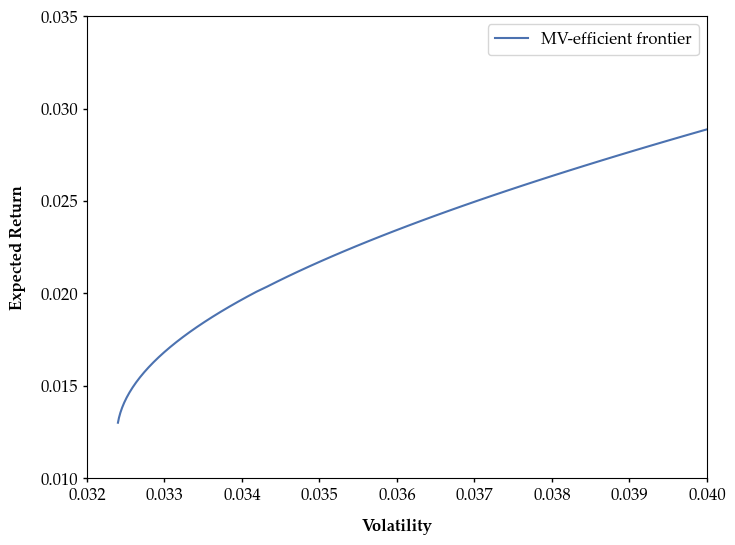

In [5]:
f, ax = plt.subplots(figsize = (8, 6))

sns.lineplot(data = output, x = 'std', y = 'target', ax = ax, label = 'MV-efficient frontier')

ax.set_xlim(0.032, 0.04)
ax.set_ylim(0.01, 0.035)

ax.set_xlabel('Volatility', fontsize = 12, fontweight = 'bold', labelpad = 10)
ax.set_ylabel('Expected Return', fontsize = 12, fontweight = 'bold', labelpad = 10)

plt.show()

## END